In [1]:
import sys
import time
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt

sys.path.append('..')
from src.kernels import exp_kernel, complex_exp_kernel, complex_discrete_kernel
from src.probability import Distribution
from src.spectral_transforms import psi_real_to_circle, psi_inv_circle_to_real, B_real, B_circle
from src.numerical import trap_quad, fourier_quad, conv_trap, conv_fourier, volterra_cm_numerical_inversion, volterra_pd_numerical_inversion
from src.plotting import plot_real_distribution, plot_discrete

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=8)
plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r"\usepackage{amsfonts}" + "\n" + r"\usepackage{amsmath}" + "\n" + r"\usepackage{amssymb}"
})

In [2]:
# Define analytical spectral distribution lambda
a = 0.9
density = None #lambda theta: np.real(2/(1 - a*np.exp(1j*theta)))
atoms = np.array([-2, -1, 1, 2])
atom_wts = np.array([0.5, 1, 1, 0.5])
quad_pts, quad_wts = fourier_quad(-np.pi, np.pi, int(1e4))
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts, periodic_domain=(-np.pi, np.pi))

Ts = np.array([1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6], dtype=np.int64)
trials = 100
numTs = len(Ts)

spectral_errs = np.zeros((numTs, trials))
spectral_errs[:] = np.nan
spectral_timings = np.zeros((numTs, trials))
spectral_timings[:] = np.nan

toeplitz_errs = np.zeros((numTs, trials))
toeplitz_errs[:] = np.nan
toeplitz_timings = np.zeros((numTs, trials))
toeplitz_timings[:] = np.nan

triangular_errs = np.zeros((numTs, trials))
triangular_errs[:] = np.nan
triangular_timings = np.zeros((numTs, trials))
triangular_timings[:] = np.nan

for i in range(numTs):
    print(i)
    T = Ts[i]
    t = np.arange(0, T)

    # Define Volterra equation kernel and coefficients
    K = complex_discrete_kernel(lmbda, t)
    c1 = -np.sum(atom_wts)/2
    
    # Define kernel for matrix inversion algorithms
    Kc = np.copy(K)
    Kc[0] += c1
    
    for j in range(trials):
        # Generate input trajectory x(t)
        n_interp = max(20, int(T/50))
        interp_xs = np.cumsum(np.insert(np.random.randn(n_interp), 0, 0))/np.sqrt(n_interp)
        interp_ts = np.linspace(0, T, n_interp+1)
        cs = scipy.interpolate.make_interp_spline(interp_ts, interp_xs, k=5)
        x = cs(t)
        
        # Compute output trajectory y(t)
        y = c1*x + conv_fourier(K, x, t)

        # Perform Volterra inversion with our theory
        t0 = time.time()
        mu, zeta1 = B_circle(lmbda, 2*np.imag(c1))
        J = 4*complex_discrete_kernel(mu, t)
        zeta1 = 2j*zeta1 - J[0]/2
        x_spectral = zeta1*y + conv_fourier(J, y, t)
        spectral_timings[i, j] = time.time() - t0
        spectral_errs[i, j] = np.linalg.norm(x_spectral - x) / np.linalg.norm(x)
        
        # Perform toeplitz matrix inversion with Richard-Levinson recursion
        if T <= 1e5:
            t0 = time.time()
            x_toeplitz = scipy.linalg.solve_toeplitz((Kc, np.zeros_like(Kc)), y, check_finite=False)
            toeplitz_timings[i, j] = time.time() - t0
            toeplitz_errs[i, j] = np.linalg.norm(x_toeplitz - x) / np.linalg.norm(x)
        
        # Perform triangular matrix inversion with forward substitution
        if T <= 1e4:
            A = scipy.linalg.toeplitz(Kc, np.zeros_like(Kc))
            t0 = time.time()
            x_triangular = scipy.linalg.solve_triangular(A, y, lower=True, unit_diagonal=False, check_finite=False)
            triangular_timings[i, j] = time.time() - t0
            triangular_errs[i, j] = np.linalg.norm(x_triangular - x) / np.linalg.norm(x)

        #np.savez('discrete_inversion_test.npz',
        #    Ts=Ts, spectral_errs=spectral_errs, spectral_timings=spectral_timings, 
        #    toeplitz_errs=toeplitz_errs, toeplitz_timings=toeplitz_timings, 
        #    triangular_errs=triangular_errs, triangular_timings=triangular_timings)

0
1
2
3
4
5
6
7
8
9
10


/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_76725/3468825125.py:3: RuntimeWarning: Mean of empty slice
  ax.plot(Ts, np.nanmean(toeplitz_timings, axis=1), color="violet", label="Toeplitz Inversion")
/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_76725/3468825125.py:4: RuntimeWarning: Mean of empty slice
  ax.plot(Ts, np.nanmean(triangular_timings, axis=1), color="indigo", label="Triangular Inversion")


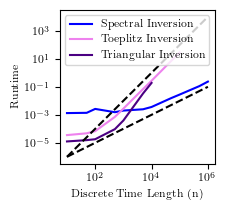

/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_76725/3468825125.py:16: RuntimeWarning: Mean of empty slice
  ax.plot(Ts, np.nanmean(toeplitz_errs, axis=1), color="violet", label="Toeplitz Inversion")
/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_76725/3468825125.py:17: RuntimeWarning: Mean of empty slice
  ax.plot(Ts, np.nanmean(triangular_errs, axis=1), color="indigo", label="Triangular Inversion")


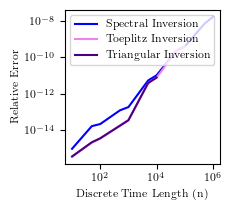

In [20]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.plot(Ts, np.nanmean(spectral_timings, axis=1), color="blue", label="Spectral Inversion")
ax.plot(Ts, np.nanmean(toeplitz_timings, axis=1), color="violet", label="Toeplitz Inversion")
ax.plot(Ts, np.nanmean(triangular_timings, axis=1), color="indigo", label="Triangular Inversion")
ax.plot(Ts, Ts**2/100000000, color="k", linestyle="--")
ax.plot(Ts, Ts/10000000, color="k", linestyle="--")
ax.set_xlabel("Discrete Time Length (n)")
ax.set_ylabel("Runtime")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(2, 2))
ax.plot(Ts, np.nanmean(spectral_errs, axis=1), color="blue", label="Spectral Inversion")
ax.plot(Ts, np.nanmean(toeplitz_errs, axis=1), color="violet", label="Toeplitz Inversion")
ax.plot(Ts, np.nanmean(triangular_errs, axis=1), color="indigo", label="Triangular Inversion")
ax.set_xlabel("Discrete Time Length (n)")
ax.set_ylabel("Relative Error")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend()
plt.show()

/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_76358/825343658.py:3: RuntimeWarning: Mean of empty slice
  plt.plot(Ts, np.nanmean(triangular_errs, axis=1))


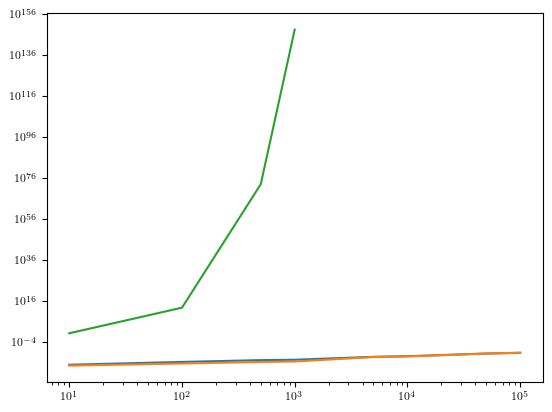

In [7]:
plt.plot(Ts, np.nanmean(spectral_errs, axis=1))
plt.plot(Ts, np.nanmean(toeplitz_errs, axis=1))
plt.plot(Ts, np.nanmean(triangular_errs, axis=1))
plt.xscale("log")
plt.yscale("log")
plt.show()

In [17]:
import time
x = time.time()
y = time.time() - x
y

3.0279159545898438e-05

In [20]:
Kc = np.copy(K)
Kc[0] += c1

In [21]:
x_toeplitz = scipy.linalg.solve_toeplitz((Kc, np.zeros_like(Kc)), y, check_finite=False)
rel_err_toeplitz = np.linalg.norm(x_toeplitz - x) / np.linalg.norm(x)
print(rel_err_toeplitz)

2.6092112641165916e-10


In [23]:
A = scipy.linalg.toeplitz(Kc, np.zeros_like(Kc))
x_triangular = scipy.linalg.solve_triangular(A, y, lower=True, unit_diagonal=True, check_finite=False)
rel_err_triangular = np.linalg.norm(x_triangular - x) / np.linalg.norm(x)
print(rel_err_triangular)

: 

: 

In [ ]:
# Define analytical spectral distribution lambda
a = 0.9
c1 = -1
density = lambda theta: np.real(2/(1 - a*np.exp(1j*theta)))
atoms = np.array([])
atom_wts = np.array([])
quad_pts, quad_wts = fourier_quad(-np.pi, np.pi, int(1e4))
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts, periodic_domain=(-np.pi, np.pi))
mu, zeta1 = B_circle(lmbda, 2*np.imag(c1))